# Event Splitter

Train the event splitter with the service-based pipeline.
This model predicts event-level edge affinities between hits, using
- event graph node/edge features,
- group-classifier probabilities,
- group-splitter probabilities,
- endpoint-regressor quantile predictions (q16/q50/q84).


In [1]:
from pathlib import Path

from pioneerml.common.evaluation.plots.loss import LossCurvesPlot
from pioneerml.common.zenml import load_step_output
from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.pipelines.training import event_splitting_pipeline

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).


In [2]:
# Build aligned event-splitting inputs.
# Expected naming: ml_output_XXX.parquet + ml_output_XXX_preds.parquet in each prediction folder.

data_dir = Path(PROJECT_ROOT) / "data"
main_paths = sorted(data_dir.glob("ml_output_*.parquet"))
group_classifier_dir = data_dir / "group_classifier"
group_splitter_dir = data_dir / "group_splitter"
endpoint_dir = data_dir / "endpoint_regressor"

# Example: uncomment to train on a smaller subset
main_paths = main_paths[:1]


def _pick_pred(pred_dir: Path, main_path: Path) -> Path | None:
    primary = pred_dir / f"{main_path.stem}_preds.parquet"
    if primary.exists():
        return primary
    latest = pred_dir / f"{main_path.stem}_preds_latest.parquet"
    if latest.exists():
        return latest
    return None

paired = []
missing = []
for main_path in main_paths:
    gc = _pick_pred(group_classifier_dir, main_path)
    gs = _pick_pred(group_splitter_dir, main_path)
    ep = _pick_pred(endpoint_dir, main_path)
    if gc is not None and gs is not None and ep is not None:
        paired.append(
            (
                str(main_path.resolve()),
                str(gc.resolve()),
                str(gs.resolve()),
                str(ep.resolve()),
            )
        )
    else:
        missing.append(main_path.name)

if not paired:
    raise RuntimeError(
        "No fully aligned event-splitting input sets found. "
        "Run group-classifier, group-splitter, and endpoint-regressor inference first."
    )
if missing:
    print(f"Warning: skipping {len(missing)} shard(s) with missing prerequisites: {missing[:5]}")

parquet_paths = [p[0] for p in paired]
group_probs_parquet_paths = [p[1] for p in paired]
group_splitter_parquet_paths = [p[2] for p in paired]
endpoint_parquet_paths = [p[3] for p in paired]

print(f"Using {len(parquet_paths)} shard(s).")


Using 1 shard(s).


In [3]:
# Run the training pipeline
base_loader_config = {
    "mode": "train",
    #"batch_size": 8,
    "chunk_row_groups": 4,
    "chunk_workers": 0,
    "use_group_probs": True,
    "use_splitter_probs": True,
    "use_endpoint_preds": True,
    "train_fraction": 0.80,
    "val_fraction": 0.10,
    "test_fraction": 0.10,
    "split_seed": 0,
}

pipeline_config = {
    "loader": {
        "config_json": {"mode": "train"},
    },
    "hpo": {
        "enabled": True,
        "n_trials": 4,
        "max_epochs": 10,
        "early_stopping": {
            "enabled": True,
            "monitor": "val_loss",
            "mode": "min",
            "patience": 2,
            "min_delta": 0.05,
            "min_delta_mode": "relative",
        },
        "compile": {"enabled": False, "mode": "reduce-overhead"},
        "storage": f"sqlite:///{PROJECT_ROOT}/.optuna/event_splitter_hpo.db",
        "loader_config": {
            "base": dict(base_loader_config),
            "train": {"split": "train", "sample_fraction": 0.125},
            "val": {"split": "val", "sample_fraction": 0.125},
        },
    },
    "train": {
        "max_epochs": 25,
        "early_stopping": {
            "enabled": True,
            "monitor": "val_loss",
            "mode": "min",
            "patience": 5,
            "min_delta": 0.05,
            "min_delta_mode": "relative",
        },
        "compile": {"enabled": False, "mode": "reduce-overhead"},
        "loader_config": {
            "base": dict(base_loader_config),
            "train": {"split": "train", "sample_fraction": None},
            "val": {"split": "val", "sample_fraction": None},
        },
    },
    "evaluate": {
        "threshold": 0.5,
        "loader_config": {
            "base": dict(base_loader_config),
            "evaluate": {"split": "test", "sample_fraction": None},
        },
    },
    "export": {
        "prefer_cuda": True,
        "export_dir": str(PROJECT_ROOT / "trained_models" / "event_splitter"),
    },
}

run = event_splitting_pipeline.with_options(enable_cache=False)(
    parquet_paths=parquet_paths,
    group_probs_parquet_paths=group_probs_parquet_paths,
    group_splitter_parquet_paths=group_splitter_parquet_paths,
    endpoint_parquet_paths=endpoint_parquet_paths,
    pipeline_config=pipeline_config,
)


Initiating a new run for the pipeline: event_splitting_pipeline.
Caching is disabled by default for event_splitting_pipeline.
Using user: default
Using stack: default
  deployer: default
  artifact_store: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step load_event_splitter_dataset has started.
Step load_event_splitter_dataset has finished in 0.199s.
Step tune_event_splitter has started.


[I 2026-02-19 02:12:39,010] Using an existing study with name 'event_splitter_hpo' instead of creating a new one.


[tune_event_splitter] GPU available: True (cuda), used: True
[tune_event_splitter] TPU available: False, using: 0 TPU cores
[tune_event_splitter] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_event_splitter] You are using a CUDA device ('NVIDIA GeForce RTX 5070') that has Tensor Cores. To properly utilize them, you should set torch.set_float32_matmul_precision('medium' | 'high') which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[tune_event_splitter] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ EventSplitter     │  215 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 215 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 215 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 27                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[tune_event_splitter] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[tune_event_splitter] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.



[I 2026-02-19 02:12:41,552] Trial 4 finished with value: 0.6582788228988647 and parameters: {'batch_size_exp': 7, 'heads': 6, 'hidden': 120, 'layers': 1, 'dropout': 0.15405064521977455, 'lr': 0.0001867456113255442, 'weight_decay': 5.724141049908254e-05}. Best is trial 3 with value: 0.3503625988960266.


[tune_event_splitter] GPU available: True (cuda), used: True
[tune_event_splitter] TPU available: False, using: 0 TPU cores
[tune_event_splitter] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_event_splitter] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ EventSplitter     │  1.6 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.6 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.6 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 75                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-19 02:12:45,264] Trial 5 finished with value: 0.5440546870231628 and parameters: {'batch_size_exp': 5, 'heads': 3, 'hidden': 177, 'layers': 4, 'dropout': 0.1450952828404234, 'lr': 0.00016348102133635048, 'weight_decay': 6.7795560943684445e-06}. Best is trial 3 with value: 0.3503625988960266.


[tune_event_splitter] GPU available: True (cuda), used: True
[tune_event_splitter] TPU available: False, using: 0 TPU cores
[tune_event_splitter] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_event_splitter] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ EventSplitter     │  1.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 75                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-19 02:12:49,667] Trial 6 finished with value: 0.44683316349983215 and parameters: {'batch_size_exp': 5, 'heads': 6, 'hidden': 168, 'layers': 4, 'dropout': 0.08445624939973356, 'lr': 0.0002970780232146362, 'weight_decay': 1.140045642565547e-05}. Best is trial 3 with value: 0.3503625988960266.


[tune_event_splitter] GPU available: True (cuda), used: True
[tune_event_splitter] TPU available: False, using: 0 TPU cores
[tune_event_splitter] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_event_splitter] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ EventSplitter     │  651 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 651 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 651 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 27                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-19 02:12:51,108] Trial 7 finished with value: 0.6553297638893127 and parameters: {'batch_size_exp': 7, 'heads': 5, 'hidden': 210, 'layers': 1, 'dropout': 0.19255373423254588, 'lr': 0.0001492754901313367, 'weight_decay': 0.00017378551278257712}. Best is trial 3 with value: 0.3503625988960266.


Step tune_event_splitter has finished in 12.283s.
Step train_event_splitter has started.
[train_event_splitter] GPU available: True (cuda), used: True
[train_event_splitter] TPU available: False, using: 0 TPU cores
[train_event_splitter] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[train_event_splitter] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ EventSplitter     │  1.9 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.9 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[train_event_splitter] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[train_event_splitter] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.



[train_event_splitter] No materializer is registered for type <class 'pioneerml.common.pipeline.services.training.utils.graph_lightning_module.GraphLightningModule'>, so the default Pickle materializer was used. Pickle is not production ready and should only be used for prototyping as the artifacts cannot be loaded when running with a different Python version. Please consider implementing a custom materializer for type <class 'pioneerml.common.pipeline.services.training.utils.graph_lightning_module.GraphLightningModule'> according to the instructions at https://docs.zenml.io/concepts/artifacts/materializers
Step train_event_splitter has finished in 39.867s.
Step evaluate_event_splitter has started.
Step evaluate_event_splitter has finished in 6.985s.
Step export_event_splitter has started.
Step export_event_splitter has finished in 0.669s.
Pipeline run has finished in 1m2s.


hpo_params: {'lr': 0.006342744133632914, 'weight_decay': 1.4758895482962393e-05, 'batch_size': 32, 'study_name': 'event_splitter_hpo', 'storage': 'sqlite:////workspace/.optuna/event_splitter_hpo.db', 'model': {'in_channels': 4, 'group_prob_dimension': 3, 'splitter_prob_dimension': 3, 'endpoint_dimension': 18, 'edge_attr_dimension': 5, 'hidden': 264, 'heads': 6, 'layers': 2, 'dropout': 0.028011849664760634}}
train_epoch_loss_history: [0.9442795535050373, 0.4642255271357592, 0.418153558045347, 0.3967804574689647, 0.3827332831686137, 0.36155975455047623, 0.34239287350070896, 0.3297786030297278, 0.3103407124518118, 0.2967494909069839, 0.2838361321803409]
val_epoch_loss_history: [0.6769609964346583, 0.5109170262454724, 0.462606707549825, 0.4361728838055718, 0.40520078491191475, 0.3792043348052064, 0.3461480818080659, 0.35000706889799665, 0.351936120387851, 0.3446669174092157, 0.3567135554491257, 0.3396252752566824]
train_step_count: 286
val_step_count: 46
metrics: {'loss': 0.329849793297953

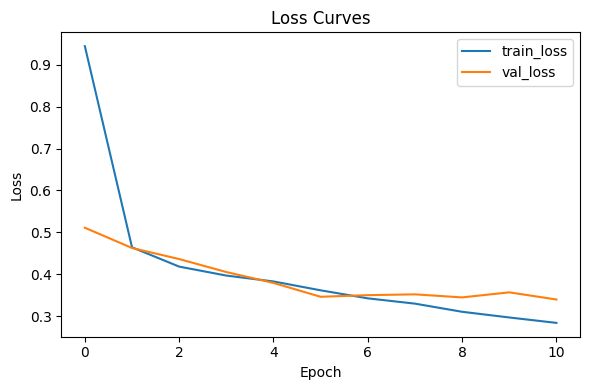

In [4]:
trained_module = load_step_output(run, "train_event_splitter")
hpo_params = load_step_output(run, "tune_event_splitter")
metrics = load_step_output(run, "evaluate_event_splitter")
export = load_step_output(run, "export_event_splitter")

print("hpo_params:", hpo_params)
if trained_module is not None:
    print("train_epoch_loss_history:", list(trained_module.train_epoch_loss_history))
    print("val_epoch_loss_history:", list(trained_module.val_epoch_loss_history))
    print("train_step_count:", len(trained_module.train_loss_history))
    print("val_step_count:", len(trained_module.val_loss_history))
print("metrics:", metrics)
print("export:", export)

if trained_module is None:
    raise RuntimeError("No trained module loaded from pipeline run.")
LossCurvesPlot().render(trained_module, show=True)
